
# Data Loading Section

In [2]:
# import important libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import floor
import os
import torchvision.models
import copy

use_cuda = True #enable usage of cuda GPU

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Loading the data 
#Toby's file directory paths (Note the MyDrive)
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'



Archive:  /content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip
  inflating: /root/datasets/test/compost_other/O_2130.jpg  
  inflating: /root/datasets/test/compost_other/compost_tampons (18).jpg  
  inflating: /root/datasets/test/compost_other/O_5547.jpg  
  inflating: /root/datasets/test/compost_other/O_2511.jpg  
  inflating: /root/datasets/test/compost_other/O_2060.jpg  
  inflating: /root/datasets/test/garbage/more_wrap (3).jpg  
  inflating: /root/datasets/test/compost_other/O_2891.jpg  
  inflating: /root/datasets/test/compost_other/gbg_wrappers_papertowels (48).jpg  
  inflating: /root/datasets/test/compost_other/O_2674.jpg  
  inflating: /root/datasets/test/compost_other/O_2610.jpg  
  inflating: /root/datasets/test/garbage/gbgblackplastic (45).jpg  
  inflating: /root/datasets/test/compost_other/download (2).jpg  
  inflating: /root/datasets/test/compost_other/images (17).jpg  
  inflating: /root/datasets/test/garbage/gbg_wrappers_papertowels (83).jpg  
  inf

In [ ]:
# Loading the data
# Everyone else's file directory paths (Note the SharedDrive)
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'


In [5]:
train_path = '/root/datasets/train'
val_path = '/root/datasets/val'
test_path = '/root/datasets/test'
tiny_path = '/root/datasets/tiny'

In [6]:
# Load the tensors
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

# Model and Training Functions and Classes

In [7]:
'''
Functions for training and getting accuracy
'''
def train(model, train_set, val_set, batch_size=64, num_epochs=1, learning_rate=0.001, optimizer_selection="SGD"):
  iters = np.zeros(num_epochs)
  losses = np.zeros(num_epochs)
  train_acc = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)

  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1000)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)#, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)#, shuffle=True)

  #get the parameters that require updating
  params_to_update = []
  for name,param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)      

  #use Cross entropy loss and SGD or Adam depending on user input
  criterion = nn.CrossEntropyLoss()
  if (optimizer_selection == "SGD"):
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
  elif (optimizer_selection == "Adam"):
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
  else:
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      for i, data in enumerate(train_loader, 0):
          imgs, labels = data 
        
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          #############################################
          
            
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          n += 1

      # save the current training information
      iters[epoch] = epoch 
      losses[epoch] = (float(loss)/batch_size)             # compute *average* loss
      train_acc[epoch] = get_accuracy(model, train_loader) # compute training accuracy 
      val_acc[epoch] = get_accuracy(model, val_loader)  # compute validation accuracy

          
          

      #printing out data
      if epoch % 10==0:
        print(("Epoch {}: Train accuracy: {}, Training Loss: {}, Validation Accuracy: {}").format(
                    epoch + 1,
                    train_acc[epoch],
                    losses[epoch],
                    val_acc[epoch]))

      # Save the current model (checkpoint) to a file
      if hasattr(model, 'name'):
        name = model.name
      else:
        name = "WasteNet"
      model_path = get_model_name(name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)


  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

# calculates accuracy
def get_accuracy(model, loader):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

def get_accuracy_of_label(model, loader, label):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model consisting of all the hyperparameter values

  Args:
      config: Configuration object containing the hyperparameters
  Returns:
      path: A string with the hyperparameter name and value concatenated
  """
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                  batch_size,
                                                  learning_rate,
                                                  epoch)
  return path  

In [8]:
# Models for transfer learning
resnet18 = torchvision.models.resnet18(pretrained=True)
alexnet = torchvision.models.alexnet(pretrained=True)
googlenet = torchvision.models.googlenet(pretrained=True)
resnet152 = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [9]:
# function to transfer learning model features as tensors into folder
def save_features(model, model_name, dataset, directory, classes):
  '''
  model: the chosen transfer learning model
  directory: This is the directory where we want to save the tensors
  dataset: pass in tensor dataset
  classes: pass in array of list of classes'''
  

  loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)
  os.mkdir(directory)

  n = 0 # use this to track the number of the file
  for imgs, labels in loader:
    # extract features and save as tensors
    features = model(imgs)
    tensor_features = torch.from_numpy(features.detach().numpy())

    #create the class directory if it doesn't exist
    if (not os.path.exists(directory + '/' + classes[labels])):
      os.mkdir(directory + '/' + classes[labels])

    #save tensor file as a file
    #can be saved as a .pt file: https://pytorch.org/docs/stable/generated/torch.save.html
    torch.save(tensor_features.squeeze(0), directory + '/' + classes[labels] + '/' + model_name + '_' + str(n) + '.pt')

    n = n+1

In [10]:
class Waste_Classifier_ANN(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_ANN, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [11]:
class Waste_Classifier_MLP(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_MLP, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 30)
    self.fc3 = nn.Linear(30, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    #print(x.shape)
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [21]:
class Waste_Classifier_CNN(nn.Module):

      def __init__(self,name="WasteNetCNN", hidden_size=256):
          self.name = name
          super(Waste_Classifier_CNN, self).__init__()
          self.conv1 = nn.Conv2d(hidden_size, 600, 2) #in_channels, out_chanels, kernel_size
          self.conv2 = nn.Conv2d(600, 1000, 2) #in_channels, out_chanels, kernel_size
          
          self.fc1 = nn.Linear(1000*4*4, 64)
          self.fc2 = nn.Linear(64, 10)
          self.hidden_size = hidden_size

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = F.relu(self.conv2(x))
          x = x.view(-1, 1000*4*4)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [13]:
class Waste_Classifier_One_Linear_Layer(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_One_Linear_Layer, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = self.fc1(x)
    return x

# Predictions and Testing --> AlexNet

In [14]:
# save Alex Net features first: Trying this model first
data_dir = '/root/datasets/AlexNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = alexnet.features
save_features(model, "alexnet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "alexnet", train_set, train_dir, train_set.classes)
save_features(model, "alexnet", val_set, val_dir, val_set.classes)
save_features(model, "alexnet", test_set, test_dir, test_set.classes)


In [15]:
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.26666666666666666, Training Loss: 0.07695200443267822, Validation Accuracy: 0.26666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07317289511362711, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06731022993723551, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.060487449169158936, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 0.9333333333333333, Training Loss: 0.053065943717956546, Validation Accuracy: 0.9333333333333333
Epoch 6: Train accuracy: 0.9333333333333333, Training Loss: 0.045085410277048744, Validation Accuracy: 0.9333333333333333
Epoch 7: Train accuracy: 0.9333333333333333, Training Loss: 0.037086459000905354, Validation Accuracy: 0.9333333333333333
Epoch 8: Train accuracy: 0.9666666666666667, Training Loss: 0.029751022656758625, Validation Accuracy: 0.9666666666666667
Epoch 9: Train accuracy: 1.0, Training Loss: 0.023398

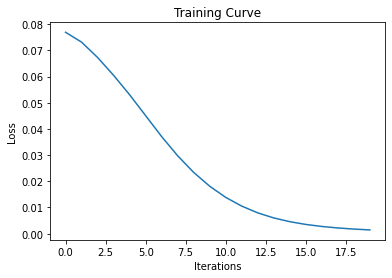

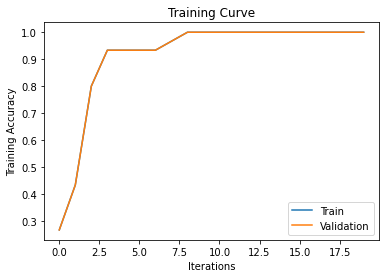

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Alex Net
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_tiny_set, feature_tiny_set, batch_size=30, num_epochs=20, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10965848452508005, Training Loss: 0.018743792548775673, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10939167556029883, Training Loss: 0.01851542294025421, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10885805763073639, Training Loss: 0.018370766192674637, Validation Accuracy: 0.12393162393162394
Epoch 4: Train accuracy: 0.08911419423692636, Training Loss: 0.01829303428530693, Validation Accuracy: 0.09188034188034189
Epoch 5: Train accuracy: 0.13660618996798293, Training Loss: 0.018264027312397957, Validation Accuracy: 0.1282051282051282
Epoch 6: Train accuracy: 0.17849519743863393, Training Loss: 0.017810843884944916, Validation Accuracy: 0.1581196581196581
Epoch 7: Train accuracy: 0.14300960512273211, Training Loss: 0.017581460997462273, Validation Accuracy: 0.13675213675213677
Epoch 8: Train accuracy: 0.14701173959445038, Training Loss: 0.01744789630174637, Validation Accuracy: 0.13675213675213677
Epoch 9: Trai

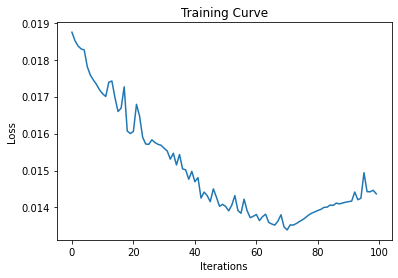

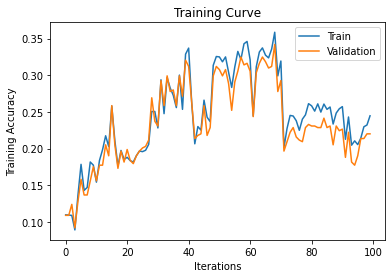

Final Training Accuracy: 0.24466382070437567
Final Validation Accuracy: 0.22008547008547008


In [ ]:
#Do Training with AlexNet
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

Epoch 1: Train accuracy: 0.1376734258271078, Training Loss: 0.018297206610441208, Validation Accuracy: 0.14102564102564102
Epoch 2: Train accuracy: 0.05496264674493063, Training Loss: 0.018605642020702362, Validation Accuracy: 0.04487179487179487
Epoch 3: Train accuracy: 0.1376734258271078, Training Loss: 0.018509071320295334, Validation Accuracy: 0.14102564102564102
Epoch 4: Train accuracy: 0.217982924226254, Training Loss: 0.018029946833848953, Validation Accuracy: 0.2222222222222222
Epoch 5: Train accuracy: 0.1923692636072572, Training Loss: 0.01765989512205124, Validation Accuracy: 0.19658119658119658
Epoch 6: Train accuracy: 0.21211312700106724, Training Loss: 0.0174824558198452, Validation Accuracy: 0.1987179487179487
Epoch 7: Train accuracy: 0.2929562433297759, Training Loss: 0.017423495650291443, Validation Accuracy: 0.3141025641025641
Epoch 8: Train accuracy: 0.35965848452508004, Training Loss: 0.01714729517698288, Validation Accuracy: 0.35683760683760685
Epoch 9: Train accura

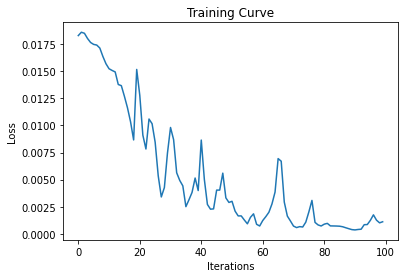

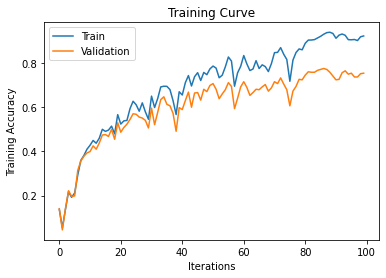

Final Training Accuracy: 0.9228922091782283
Final Validation Accuracy: 0.7542735042735043


In [ ]:
alexNetClassify = Waste_Classifier_MLP(name="Waste_AlexNetMLP")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

alexnet learning rate: 0.005, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.10538954108858058, Training Loss: 0.07583829760551453, Validation Accuracy: 0.1047008547008547
Epoch 11: Train accuracy: 0.15848452508004268, Training Loss: 0.06836025416851044, Validation Accuracy: 0.14743589743589744
Epoch 21: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 31: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 41: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 51: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 61: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 71: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, 

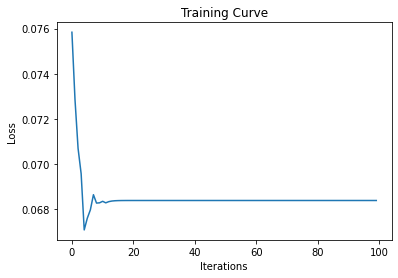

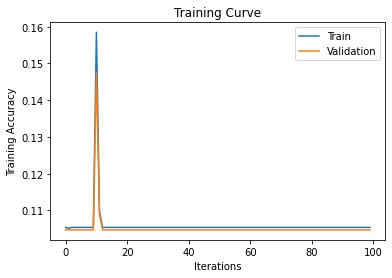

Final Training Accuracy: 0.10538954108858058
Final Validation Accuracy: 0.1047008547008547
alexnet learning rate: 0.005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.10859124866595518, Training Loss: 0.037236537784338, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.10992529348986126, Training Loss: 0.034725017845630646, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.12966915688367128, Training Loss: 0.03483998030424118, Validation Accuracy: 0.12606837606837606
Epoch 31: Train accuracy: 0.1328708644610459, Training Loss: 0.03441192954778671, Validation Accuracy: 0.12606837606837606
Epoch 41: Train accuracy: 0.13500533617929564, Training Loss: 0.03429357707500458, Validation Accuracy: 0.1282051282051282
Epoch 51: Train accuracy: 0.12113127001067236, Training Loss: 0.03420800715684891, Validation Accuracy: 0.11324786324786325
Epoch 61: Train accuracy: 0.14487726787620064, Training Loss: 0.03417535126209259, Validation Accuracy: 0.1

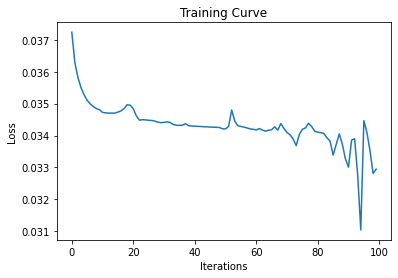

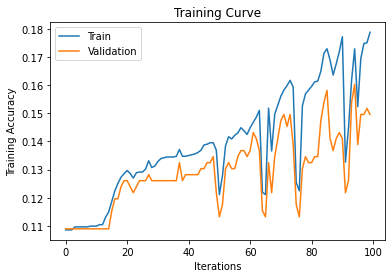

Final Training Accuracy: 0.17876200640341516
Final Validation Accuracy: 0.14957264957264957
alexnet learning rate: 0.005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.10058697972251868, Training Loss: 0.01814110018312931, Validation Accuracy: 0.11752136752136752
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.016373930498957634, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.10779082177161152, Training Loss: 0.014738922007381916, Validation Accuracy: 0.10897435897435898
Epoch 31: Train accuracy: 0.10779082177161152, Training Loss: 0.016285600140690804, Validation Accuracy: 0.10897435897435898
Epoch 41: Train accuracy: 0.18623265741728923, Training Loss: 0.01583945006132126, Validation Accuracy: 0.1858974358974359
Epoch 51: Train accuracy: 0.21398078975453574, Training Loss: 0.015605239197611809, Validation Accuracy: 0.21794871794871795
Epoch 61: Train accuracy: 0.22011739594450375, Training Loss: 0.015042237006127834, Validation Accu

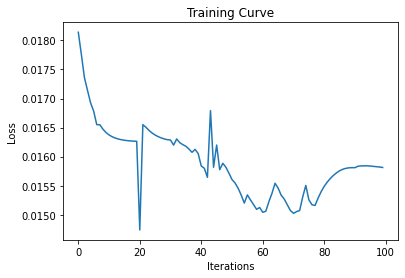

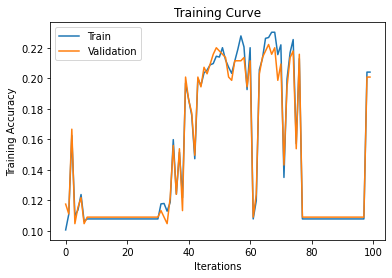

Final Training Accuracy: 0.20410885805763074
Final Validation Accuracy: 0.20085470085470086
alexnet learning rate: 0.005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.10138740661686232, Training Loss: 0.011387553997337818, Validation Accuracy: 0.10042735042735043
Epoch 11: Train accuracy: 0.41275346851654215, Training Loss: 0.00808058399707079, Validation Accuracy: 0.38675213675213677
Epoch 21: Train accuracy: 0.5170757737459979, Training Loss: 0.007090535946190357, Validation Accuracy: 0.4722222222222222
Epoch 31: Train accuracy: 0.6310032017075774, Training Loss: 0.004942467901855707, Validation Accuracy: 0.6025641025641025
Epoch 41: Train accuracy: 0.807897545357524, Training Loss: 0.0035104507114738226, Validation Accuracy: 0.7286324786324786
Epoch 51: Train accuracy: 0.878068303094984, Training Loss: 0.0010363617911934853, Validation Accuracy: 0.7628205128205128
Epoch 61: Train accuracy: 0.6630202774813234, Training Loss: 0.005415405612438917, Validation Accuracy: 0

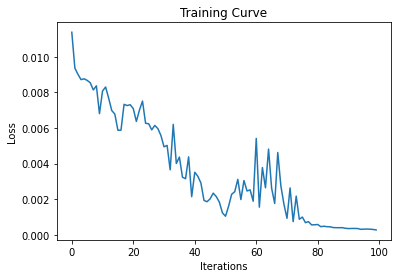

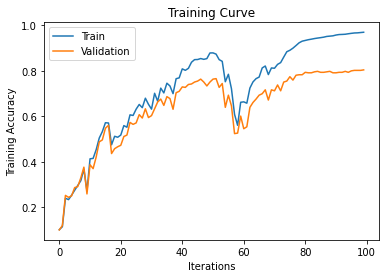

Final Training Accuracy: 0.9687833511205977
Final Validation Accuracy: 0.8034188034188035
alexnet learning rate: 0.003, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.10965848452508005, Training Loss: 0.07253502309322357, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.06820835918188095, Validation Accuracy: 0.10683760683760683
Epoch 21: Train accuracy: 0.10965848452508005, Training Loss: 0.06816370785236359, Validation Accuracy: 0.10897435897435898
Epoch 31: Train accuracy: 0.10965848452508005, Training Loss: 0.0681525394320488, Validation Accuracy: 0.10897435897435898
Epoch 41: Train accuracy: 0.10965848452508005, Training Loss: 0.068203404545784, Validation Accuracy: 0.10897435897435898
Epoch 51: Train accuracy: 0.10965848452508005, Training Loss: 0.06820394843816757, Validation Accuracy: 0.10897435897435898
Epoch 61: Train accuracy: 0.10965848452508005, Training Loss: 0.06820392608642578, Validation Accuracy: 0.10

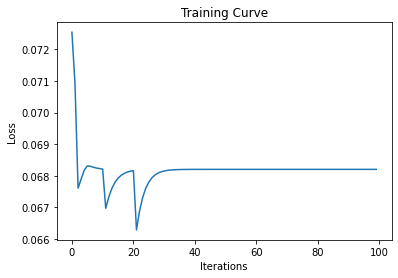

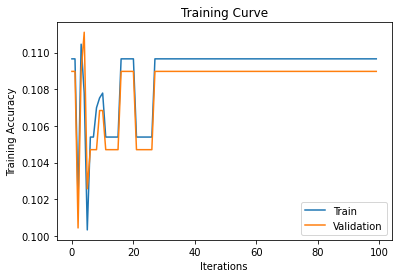

Final Training Accuracy: 0.10965848452508005
Final Validation Accuracy: 0.10897435897435898
alexnet learning rate: 0.003, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.10192102454642477, Training Loss: 0.03569846227765083, Validation Accuracy: 0.10256410256410256
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.0342736691236496, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.17662753468516543, Training Loss: 0.03382705897092819, Validation Accuracy: 0.17735042735042736
Epoch 31: Train accuracy: 0.14327641408751335, Training Loss: 0.03352948650717735, Validation Accuracy: 0.1346153846153846
Epoch 41: Train accuracy: 0.10965848452508005, Training Loss: 0.03399084880948067, Validation Accuracy: 0.10897435897435898
Epoch 51: Train accuracy: 0.10965848452508005, Training Loss: 0.034268368035554886, Validation Accuracy: 0.10897435897435898
Epoch 61: Train accuracy: 0.10965848452508005, Training Loss: 0.03433440998196602, Validation Accuracy: 

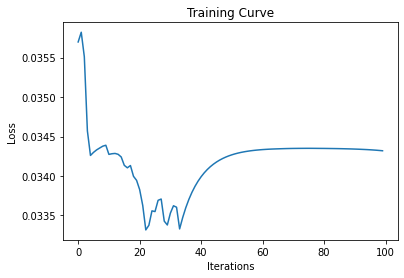

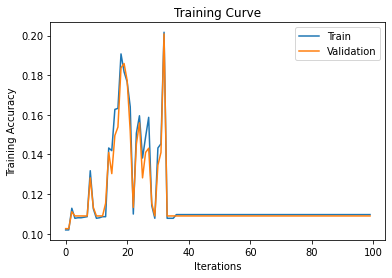

Final Training Accuracy: 0.10965848452508005
Final Validation Accuracy: 0.10897435897435898
alexnet learning rate: 0.003, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.10138740661686232, Training Loss: 0.018057864159345627, Validation Accuracy: 0.10042735042735043
Epoch 11: Train accuracy: 0.2833511205976521, Training Loss: 0.0162343792617321, Validation Accuracy: 0.2670940170940171
Epoch 21: Train accuracy: 0.2692102454642476, Training Loss: 0.013825329020619392, Validation Accuracy: 0.27350427350427353
Epoch 31: Train accuracy: 0.5434898612593383, Training Loss: 0.010330040007829666, Validation Accuracy: 0.5149572649572649
Epoch 41: Train accuracy: 0.5557630736392742, Training Loss: 0.010906603187322617, Validation Accuracy: 0.5149572649572649
Epoch 51: Train accuracy: 0.6520811099252934, Training Loss: 0.009198937565088272, Validation Accuracy: 0.5982905982905983
Epoch 61: Train accuracy: 0.5301494130202775, Training Loss: 0.010303733870387077, Validation Accuracy: 0.5

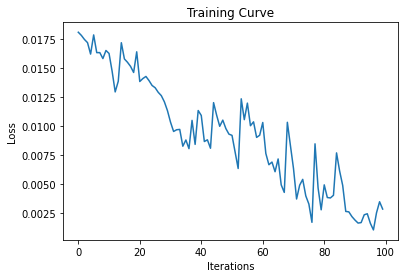

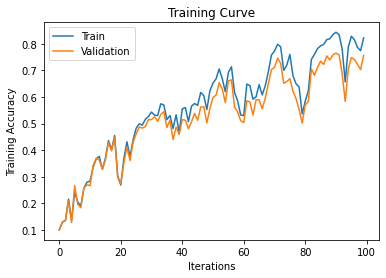

Final Training Accuracy: 0.8223052294557097
Final Validation Accuracy: 0.7564102564102564
alexnet learning rate: 0.003, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.13260405549626467, Training Loss: 0.010511385276913643, Validation Accuracy: 0.14316239316239315
Epoch 11: Train accuracy: 0.62940234791889, Training Loss: 0.005111257545650005, Validation Accuracy: 0.6025641025641025
Epoch 21: Train accuracy: 0.7590715048025614, Training Loss: 0.002192719606682658, Validation Accuracy: 0.717948717948718
Epoch 31: Train accuracy: 0.8823372465314835, Training Loss: 0.001624037977308035, Validation Accuracy: 0.7841880341880342
Epoch 41: Train accuracy: 0.913820704375667, Training Loss: 0.0013192319311201572, Validation Accuracy: 0.782051282051282
Epoch 51: Train accuracy: 0.8519210245464247, Training Loss: 0.0012003184529021382, Validation Accuracy: 0.7243589743589743
Epoch 61: Train accuracy: 0.9690501600853789, Training Loss: 0.00044753303518518806, Validation Accuracy: 0.816

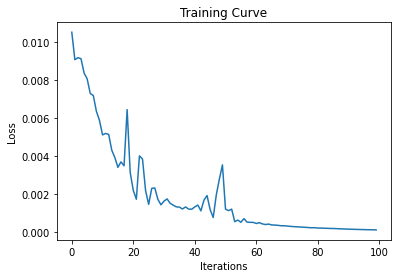

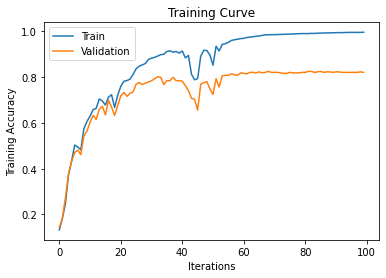

Final Training Accuracy: 0.9957310565635006
Final Validation Accuracy: 0.8205128205128205
alexnet learning rate: 0.001, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.11819637139807898, Training Loss: 0.0711205005645752, Validation Accuracy: 0.10256410256410256
Epoch 11: Train accuracy: 0.17742796157950907, Training Loss: 0.0615570992231369, Validation Accuracy: 0.16452991452991453
Epoch 21: Train accuracy: 0.1552828175026681, Training Loss: 0.027855953201651573, Validation Accuracy: 0.14957264957264957
Epoch 31: Train accuracy: 0.19743863393810032, Training Loss: 0.008492514491081238, Validation Accuracy: 0.19444444444444445
Epoch 41: Train accuracy: 0.23505869797225187, Training Loss: 0.004764691460877657, Validation Accuracy: 0.22435897435897437
Epoch 51: Train accuracy: 0.2892209178228389, Training Loss: 0.009115282446146011, Validation Accuracy: 0.28205128205128205
Epoch 61: Train accuracy: 0.31643543223052295, Training Loss: 0.010364417918026447, Validation Accuracy: 

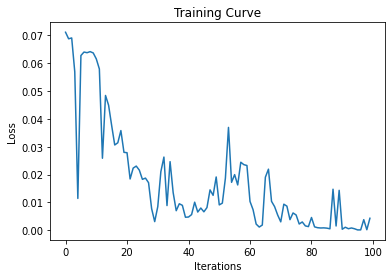

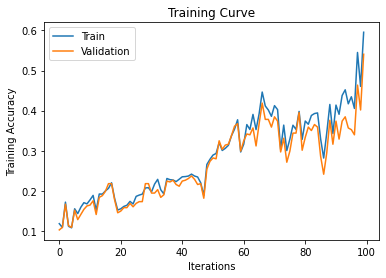

Final Training Accuracy: 0.5955176093916755
Final Validation Accuracy: 0.5405982905982906
alexnet learning rate: 0.001, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.11712913553895411, Training Loss: 0.03605714067816734, Validation Accuracy: 0.11538461538461539
Epoch 11: Train accuracy: 0.37406616862326575, Training Loss: 0.029542608186602592, Validation Accuracy: 0.36752136752136755
Epoch 21: Train accuracy: 0.5888473852721452, Training Loss: 0.019452355802059174, Validation Accuracy: 0.5576923076923077
Epoch 31: Train accuracy: 0.5971184631803629, Training Loss: 0.02087225578725338, Validation Accuracy: 0.5534188034188035
Epoch 41: Train accuracy: 0.7022411953041622, Training Loss: 0.01345179881900549, Validation Accuracy: 0.6346153846153846
Epoch 51: Train accuracy: 0.7185165421558164, Training Loss: 0.0162238497287035, Validation Accuracy: 0.6217948717948718
Epoch 61: Train accuracy: 0.8009605122732124, Training Loss: 0.006834110710769892, Validation Accuracy: 0.688034

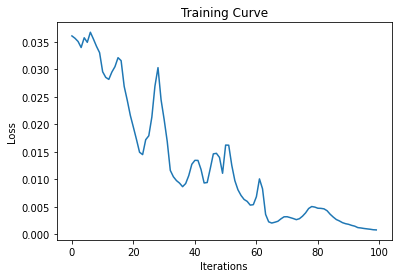

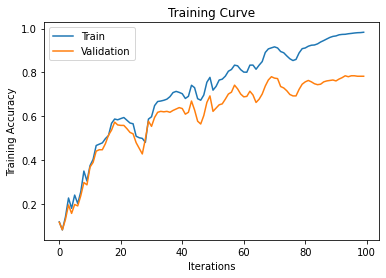

Final Training Accuracy: 0.9829242262540021
Final Validation Accuracy: 0.782051282051282
alexnet learning rate: 0.001, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.1315368196371398, Training Loss: 0.01993001624941826, Validation Accuracy: 0.11752136752136752
Epoch 11: Train accuracy: 0.6013874066168623, Training Loss: 0.011429949663579464, Validation Accuracy: 0.5811965811965812
Epoch 21: Train accuracy: 0.7030416221985059, Training Loss: 0.007763451896607876, Validation Accuracy: 0.6645299145299145
Epoch 31: Train accuracy: 0.8297758804695837, Training Loss: 0.002685488434508443, Validation Accuracy: 0.7585470085470085
Epoch 41: Train accuracy: 0.8874066168623266, Training Loss: 0.0013381601311266422, Validation Accuracy: 0.7863247863247863
Epoch 51: Train accuracy: 0.82017075773746, Training Loss: 0.0014264556812122464, Validation Accuracy: 0.7051282051282052
Epoch 61: Train accuracy: 0.9493062966915689, Training Loss: 0.000629149260930717, Validation Accuracy: 0.81623

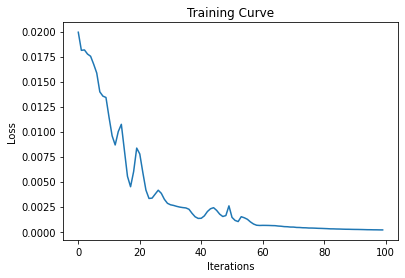

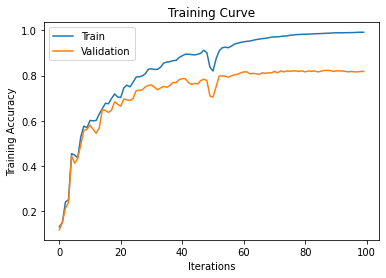

Final Training Accuracy: 0.991462113127001
Final Validation Accuracy: 0.8183760683760684
alexnet learning rate: 0.001, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.17689434364994663, Training Loss: 0.00952143408358097, Validation Accuracy: 0.16880341880341881
Epoch 11: Train accuracy: 0.6472785485592316, Training Loss: 0.005488129798322916, Validation Accuracy: 0.6196581196581197
Epoch 21: Train accuracy: 0.7769477054429029, Training Loss: 0.0030861336272209883, Validation Accuracy: 0.7414529914529915
Epoch 31: Train accuracy: 0.8444503735325507, Training Loss: 0.002056089462712407, Validation Accuracy: 0.7735042735042735
Epoch 41: Train accuracy: 0.8892742796157951, Training Loss: 0.0014965105801820755, Validation Accuracy: 0.7863247863247863
Epoch 51: Train accuracy: 0.9244930629669157, Training Loss: 0.0011354107409715652, Validation Accuracy: 0.7948717948717948
Epoch 61: Train accuracy: 0.9493062966915689, Training Loss: 0.0008879171218723059, Validation Accuracy: 0.

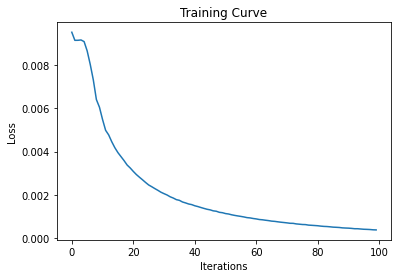

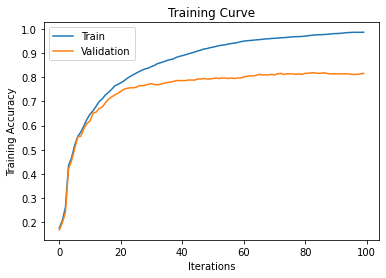

Final Training Accuracy: 0.9861259338313767
Final Validation Accuracy: 0.8162393162393162
alexnet learning rate: 0.0005, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.11926360725720384, Training Loss: 0.07078307867050171, Validation Accuracy: 0.13034188034188035
Epoch 11: Train accuracy: 0.31670224119530416, Training Loss: 0.05396021530032158, Validation Accuracy: 0.30982905982905984
Epoch 21: Train accuracy: 0.5053361792956244, Training Loss: 0.008692163974046707, Validation Accuracy: 0.47863247863247865
Epoch 31: Train accuracy: 0.4973319103521878, Training Loss: 0.003544819774106145, Validation Accuracy: 0.4700854700854701
Epoch 41: Train accuracy: 0.6942369263607258, Training Loss: 0.011164371855556965, Validation Accuracy: 0.5982905982905983
Epoch 51: Train accuracy: 0.7006403415154749, Training Loss: 0.004794280510395765, Validation Accuracy: 0.6111111111111112
Epoch 61: Train accuracy: 0.7766808964781217, Training Loss: 0.0017241897294297814, Validation Accuracy: 0.

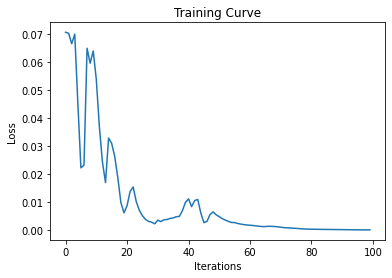

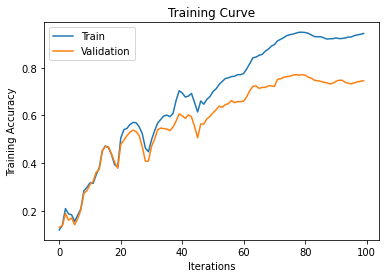

Final Training Accuracy: 0.9445037353255069
Final Validation Accuracy: 0.7457264957264957
alexnet learning rate: 0.0005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.18009605122732122, Training Loss: 0.036739885807037354, Validation Accuracy: 0.14743589743589744
Epoch 11: Train accuracy: 0.5261472785485592, Training Loss: 0.03302746266126633, Validation Accuracy: 0.49572649572649574
Epoch 21: Train accuracy: 0.6763607257203842, Training Loss: 0.021763693541288376, Validation Accuracy: 0.6367521367521367
Epoch 31: Train accuracy: 0.7969583778014941, Training Loss: 0.009691246785223484, Validation Accuracy: 0.7329059829059829
Epoch 41: Train accuracy: 0.7956243329775881, Training Loss: 0.00897977128624916, Validation Accuracy: 0.6944444444444444
Epoch 51: Train accuracy: 0.8954108858057631, Training Loss: 0.005655235145241022, Validation Accuracy: 0.7585470085470085
Epoch 61: Train accuracy: 0.9375667022411953, Training Loss: 0.003423681017011404, Validation Accuracy: 0.794

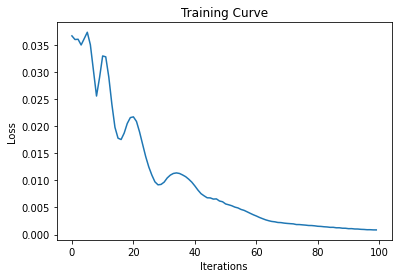

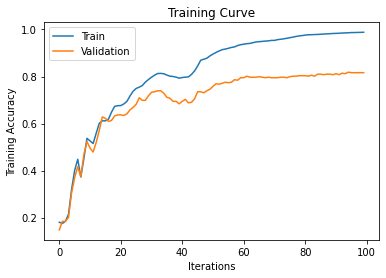

Final Training Accuracy: 0.9882604055496265
Final Validation Accuracy: 0.8162393162393162
alexnet learning rate: 0.0005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.15741728922091783, Training Loss: 0.019140388816595078, Validation Accuracy: 0.1452991452991453
Epoch 11: Train accuracy: 0.6008537886872999, Training Loss: 0.011755045503377914, Validation Accuracy: 0.5790598290598291
Epoch 21: Train accuracy: 0.7398612593383138, Training Loss: 0.006050404626876116, Validation Accuracy: 0.6965811965811965
Epoch 31: Train accuracy: 0.8068303094983992, Training Loss: 0.003755382029339671, Validation Accuracy: 0.7457264957264957
Epoch 41: Train accuracy: 0.8633938100320171, Training Loss: 0.0025999308563768864, Validation Accuracy: 0.7713675213675214
Epoch 51: Train accuracy: 0.9002134471718249, Training Loss: 0.0018637398025020957, Validation Accuracy: 0.7927350427350427
Epoch 61: Train accuracy: 0.9258271077908218, Training Loss: 0.0013498389162123203, Validation Accuracy: 0

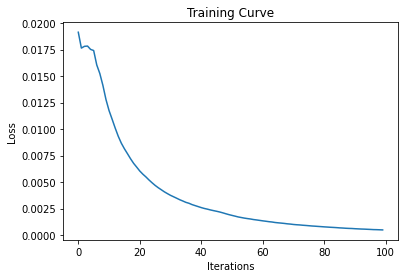

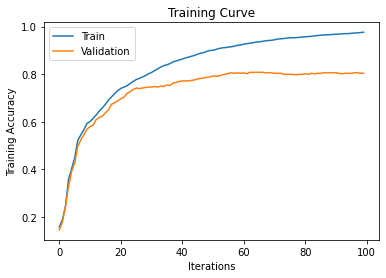

Final Training Accuracy: 0.9759871931696905
Final Validation Accuracy: 0.8034188034188035
alexnet learning rate: 0.0005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.11125933831376734, Training Loss: 0.009131680242717266, Validation Accuracy: 0.11324786324786325
Epoch 11: Train accuracy: 0.5987193169690501, Training Loss: 0.00635515758767724, Validation Accuracy: 0.5854700854700855
Epoch 21: Train accuracy: 0.7078441835645678, Training Loss: 0.0037528355605900288, Validation Accuracy: 0.6901709401709402
Epoch 31: Train accuracy: 0.7740128068303095, Training Loss: 0.0026665322948247194, Validation Accuracy: 0.7329059829059829
Epoch 41: Train accuracy: 0.8207043756670224, Training Loss: 0.0020637742709368467, Validation Accuracy: 0.7799145299145299
Epoch 51: Train accuracy: 0.8489861259338314, Training Loss: 0.0016864367062225938, Validation Accuracy: 0.782051282051282
Epoch 61: Train accuracy: 0.8754002134471718, Training Loss: 0.0014241127064451575, Validation Accuracy: 

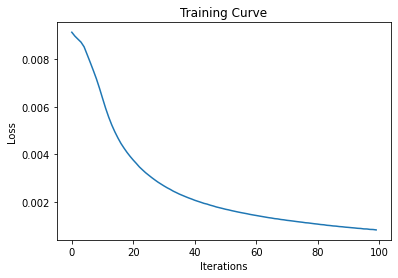

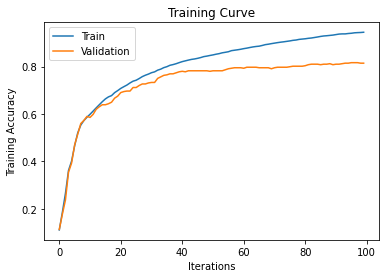

Final Training Accuracy: 0.9445037353255069
Final Validation Accuracy: 0.8141025641025641


In [16]:
learning_rate=[.005,.003,.001,.0005]
batch_size=[32,64,128,256]
for lr in learning_rate:
  for bs in batch_size:
    print("alexnet learning rate: {}, batchsize: {}".format(lr,bs))
    alexNetClassify = Waste_Classifier_MLP(name="Waste_AlexNetMLP_"+str(lr)+"_"+str(bs))
    if use_cuda and torch.cuda.is_available():
      print("cude is available")
      alexNetClassify = alexNetClassify.cuda()
    train(alexNetClassify, feature_train_set, feature_val_set, batch_size=bs, num_epochs=100, learning_rate=lr)

Best combinations:

.0005, 256  
Best Training Accuracy: 0.9445037353255069 at epoch 99  
Best Validation Accuracy: 0.8162393162393162 at epoch 95  
.0005, 128  
Best Training Accuracy: 0.9759871931696905 at epoch 99  
Best Validation Accuracy: 0.8076923076923077 at epoch 62  

.0005,  
Best Training Accuracy: 0.9882604055496265 at epoch 99  
Best Validation Accuracy: 0.8183760683760684 at epoch 94  

.001, 256  
Best Training Accuracy: 0.9861259338313767 at epoch 99  
Best Validation Accuracy: 0.8183760683760684 at epoch 82  
.001, 128  
Best Training Accuracy: 0.991462113127001 at epoch 98  
Best Validation Accuracy: 0.8226495726495726 at epoch 86  
.003, 256  
Best Training Accuracy: 0.9957310565635006 at epoch 99  
Best Validation Accuracy: 0.8247863247863247 at epoch 68  



alexnet learning rate: 0.003, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.10352187833511206, Training Loss: 0.009777395986020565, Validation Accuracy: 0.1111111111111111
Epoch 11: Train accuracy: 0.5112059765208111, Training Loss: 0.00772415567189455, Validation Accuracy: 0.47863247863247865
Epoch 21: Train accuracy: 0.6470117395944504, Training Loss: 0.004954309668391943, Validation Accuracy: 0.5918803418803419
Epoch 31: Train accuracy: 0.7497331910352187, Training Loss: 0.002517265733331442, Validation Accuracy: 0.6794871794871795
Epoch 41: Train accuracy: 0.8217716115261473, Training Loss: 0.00245446665212512, Validation Accuracy: 0.7393162393162394
Epoch 51: Train accuracy: 0.8492529348986126, Training Loss: 0.002185605000704527, Validation Accuracy: 0.7756410256410257
Epoch 61: Train accuracy: 0.9218249733191035, Training Loss: 0.0011436305940151215, Validation Accuracy: 0.7884615384615384
Epoch 71: Train accuracy: 0.9348986125933831, Training Loss: 0.0007892550202

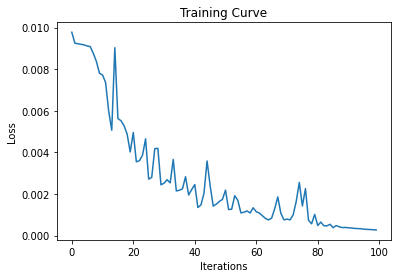

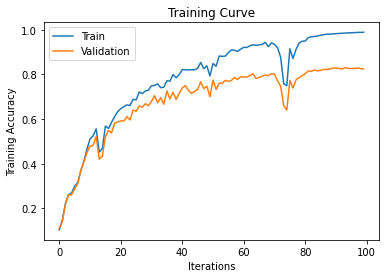

Final Training Accuracy: 0.9893276414087513
Final Validation Accuracy: 0.8247863247863247
alexnet learning rate: 0.001, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.1635538954108858, Training Loss: 0.019013021141290665, Validation Accuracy: 0.14743589743589744
Epoch 11: Train accuracy: 0.3441835645677695, Training Loss: 0.01383974775671959, Validation Accuracy: 0.3247863247863248
Epoch 21: Train accuracy: 0.5093383137673426, Training Loss: 0.006595345214009285, Validation Accuracy: 0.4829059829059829
Epoch 31: Train accuracy: 0.6875667022411953, Training Loss: 0.007214573677629232, Validation Accuracy: 0.655982905982906
Epoch 41: Train accuracy: 0.7580042689434365, Training Loss: 0.004773931577801704, Validation Accuracy: 0.6965811965811965
Epoch 51: Train accuracy: 0.8121664887940235, Training Loss: 0.00350499851629138, Validation Accuracy: 0.7286324786324786
Epoch 61: Train accuracy: 0.8615261472785486, Training Loss: 0.002159680938348174, Validation Accuracy: 0.756410

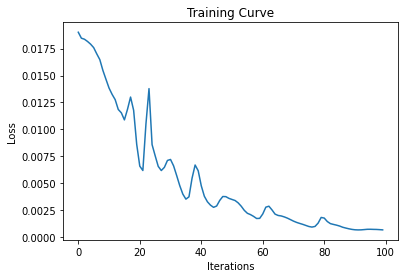

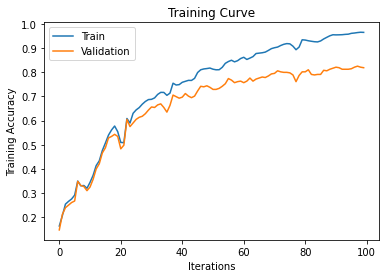

Final Training Accuracy: 0.9645144076840982
Final Validation Accuracy: 0.8183760683760684
alexnet learning rate: 0.001, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.1331376734258271, Training Loss: 0.009401144459843636, Validation Accuracy: 0.12393162393162394
Epoch 11: Train accuracy: 0.47491995731056563, Training Loss: 0.007574953138828278, Validation Accuracy: 0.4551282051282051
Epoch 21: Train accuracy: 0.6374066168623266, Training Loss: 0.00492419209331274, Validation Accuracy: 0.6175213675213675
Epoch 31: Train accuracy: 0.7238527214514408, Training Loss: 0.003419311949983239, Validation Accuracy: 0.7051282051282052
Epoch 41: Train accuracy: 0.7817502668089648, Training Loss: 0.002659730613231659, Validation Accuracy: 0.7435897435897436
Epoch 51: Train accuracy: 0.8132337246531484, Training Loss: 0.002220788039267063, Validation Accuracy: 0.7606837606837606
Epoch 61: Train accuracy: 0.844717182497332, Training Loss: 0.0019095278112217784, Validation Accuracy: 0.777

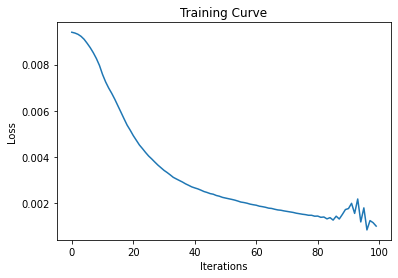

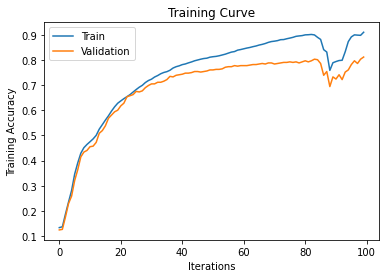

Final Training Accuracy: 0.9106189967982924
Final Validation Accuracy: 0.811965811965812
alexnet learning rate: 0.0005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.13233724653148346, Training Loss: 0.03721127286553383, Validation Accuracy: 0.14743589743589744
Epoch 11: Train accuracy: 0.30389541088580574, Training Loss: 0.029599495232105255, Validation Accuracy: 0.3055555555555556
Epoch 21: Train accuracy: 0.5274813233724653, Training Loss: 0.025506604462862015, Validation Accuracy: 0.5277777777777778
Epoch 31: Train accuracy: 0.6451440768409819, Training Loss: 0.014648090116679668, Validation Accuracy: 0.5897435897435898
Epoch 41: Train accuracy: 0.7102454642475987, Training Loss: 0.012023835442960262, Validation Accuracy: 0.6303418803418803
Epoch 51: Train accuracy: 0.7750800426894343, Training Loss: 0.012864931486546993, Validation Accuracy: 0.6923076923076923
Epoch 61: Train accuracy: 0.8231056563500534, Training Loss: 0.008472123183310032, Validation Accuracy: 0.743

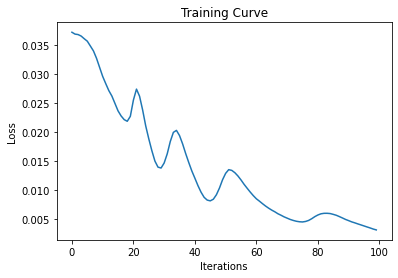

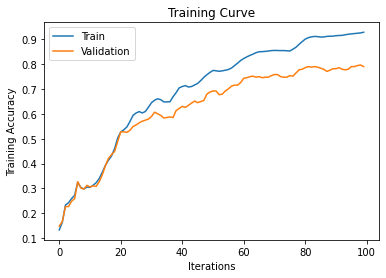

Final Training Accuracy: 0.9290288153681964
Final Validation Accuracy: 0.7905982905982906
alexnet learning rate: 0.0005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.15154749199573106, Training Loss: 0.018876168876886368, Validation Accuracy: 0.1388888888888889
Epoch 11: Train accuracy: 0.42075773745997863, Training Loss: 0.01592898555099964, Validation Accuracy: 0.41239316239316237
Epoch 21: Train accuracy: 0.5872465314834578, Training Loss: 0.010140090249478817, Validation Accuracy: 0.5811965811965812
Epoch 31: Train accuracy: 0.6688900747065102, Training Loss: 0.006778462789952755, Validation Accuracy: 0.6431623931623932
Epoch 41: Train accuracy: 0.7337246531483458, Training Loss: 0.00483902869746089, Validation Accuracy: 0.6965811965811965
Epoch 51: Train accuracy: 0.7793489861259338, Training Loss: 0.003748896298930049, Validation Accuracy: 0.7286324786324786
Epoch 61: Train accuracy: 0.814034151547492, Training Loss: 0.0030869117472320795, Validation Accuracy: 0.75

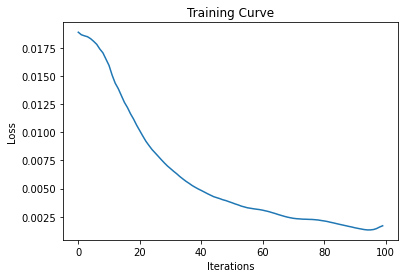

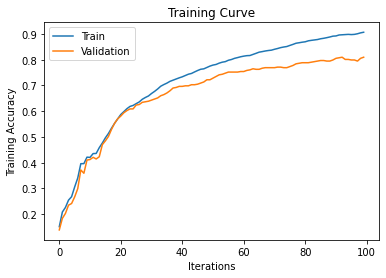

Final Training Accuracy: 0.9068836712913554
Final Validation Accuracy: 0.8098290598290598
alexnet learning rate: 0.0005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.13127001067235858, Training Loss: 0.00922627653926611, Validation Accuracy: 0.12393162393162394
Epoch 11: Train accuracy: 0.4450373532550694, Training Loss: 0.008255756460130215, Validation Accuracy: 0.4230769230769231
Epoch 21: Train accuracy: 0.5528281750266809, Training Loss: 0.006208558566868305, Validation Accuracy: 0.5170940170940171
Epoch 31: Train accuracy: 0.6419423692636073, Training Loss: 0.004540889989584684, Validation Accuracy: 0.6132478632478633
Epoch 41: Train accuracy: 0.695837780149413, Training Loss: 0.003464339766651392, Validation Accuracy: 0.6923076923076923
Epoch 51: Train accuracy: 0.7454642475987193, Training Loss: 0.0028195662889629602, Validation Accuracy: 0.7222222222222222
Epoch 61: Train accuracy: 0.7772145144076841, Training Loss: 0.0024314643815159798, Validation Accuracy: 0.7

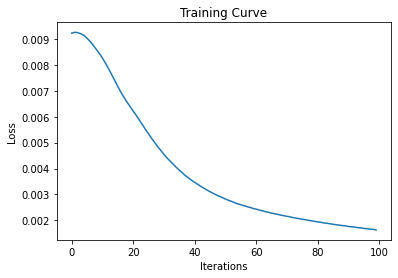

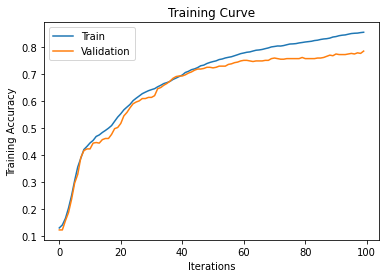

Final Training Accuracy: 0.8537886872998933
Final Validation Accuracy: 0.7841880341880342


In [22]:
lr_bs=[[.003,256],[.001,128],[.001,256],[.0005,64],[.0005,128],[.0005,256]]
for lrbs in lr_bs:
    print("alexnet learning rate: {}, batchsize: {}".format(lrbs[0],lrbs[1]))
    alexNetClassify = Waste_Classifier_CNN(name="Waste_AlexNetMLP_CNN_"+str(lrbs[0])+"_"+str(lrbs[1]))
    if use_cuda and torch.cuda.is_available():
      print("cude is available")
      alexNetClassify = alexNetClassify.cuda()
    train(alexNetClassify, feature_train_set, feature_val_set, batch_size=lrbs[1], num_epochs=100, learning_rate=lrbs[0])

# Predictions and Testing --> ResNet18

In [ ]:
# Load the tensors
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

In [ ]:
# set up the ResNet18 model
# ResNet18 Sample Tutorial: https://www.coursera.org/lecture/ai-deep-learning-capstone/pre-trained-models-with-resnet-18-review-pytorch-F0nDe
model = copy.deepcopy(resnet18)
model = nn.Sequential(*(list(resnet18.children())[0:9]))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Save resnet18 features
data_dir = '/root/datasets/ResNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model, "ResNet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "ResNet", train_set, train_dir, train_set.classes)
save_features(model, "ResNet", val_set, val_dir, val_set.classes)
save_features(model, "ResNet", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.1, Training Loss: 0.1603074073791504, Validation Accuracy: 0.1
Epoch 2: Train accuracy: 0.2, Training Loss: 0.15871734619140626, Validation Accuracy: 0.2
Epoch 3: Train accuracy: 0.3, Training Loss: 0.15428846677144367, Validation Accuracy: 0.3
Epoch 4: Train accuracy: 0.3333333333333333, Training Loss: 0.14762775103251138, Validation Accuracy: 0.3333333333333333
Epoch 5: Train accuracy: 0.5, Training Loss: 0.13903907140096028, Validation Accuracy: 0.5
Epoch 6: Train accuracy: 0.6, Training Loss: 0.12876261870066324, Validation Accuracy: 0.6
Epoch 7: Train accuracy: 0.6666666666666666, Training Loss: 0.11718636353810628, Validation Accuracy: 0.6666666666666666
Epoch 8: Train accuracy: 0.8, Training Loss: 0.10490690072377523, Validation Accuracy: 0.8
Epoch 9: Train accuracy: 0.9, Training Loss: 0.0926470677057902, Validation Accuracy: 0.9
Epoch 10: Train accuracy: 0.9, Training Loss: 0.08111704190572103, Validation Accuracy: 0.9
Epoch 11: Train accuracy: 0.933

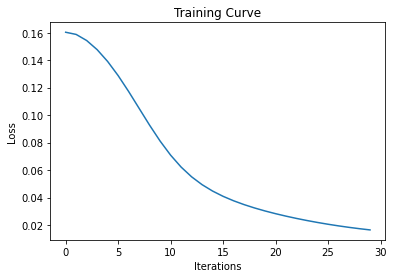

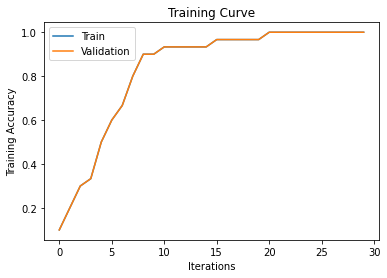

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with ResNet
resNetClassify_single_fc_overfit = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_overfit = resNetClassify_single_fc_overfit.cuda()
train(resNetClassify_single_fc_overfit, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=30, learning_rate=0.001)

Epoch 1: Train accuracy: 0.11846318036286019, Training Loss: 0.6691821217536926, Validation Accuracy: 0.1111111111111111
Epoch 2: Train accuracy: 0.27908217716115263, Training Loss: 1.3819187879562378, Validation Accuracy: 0.2692307692307692
Epoch 3: Train accuracy: 0.33271077908217717, Training Loss: 0.5319944620132446, Validation Accuracy: 0.32905982905982906
Epoch 4: Train accuracy: 0.4631803628601921, Training Loss: 0.24105893075466156, Validation Accuracy: 0.45085470085470086
Epoch 5: Train accuracy: 0.5669690501600854, Training Loss: 0.26677533984184265, Validation Accuracy: 0.5534188034188035
Epoch 6: Train accuracy: 0.576307363927428, Training Loss: 0.27617838978767395, Validation Accuracy: 0.5726495726495726
Epoch 7: Train accuracy: 0.6061899679829242, Training Loss: 0.13982103765010834, Validation Accuracy: 0.5833333333333334
Epoch 8: Train accuracy: 0.6456776947705443, Training Loss: 0.11193840950727463, Validation Accuracy: 0.6388888888888888
Epoch 9: Train accuracy: 0.6648

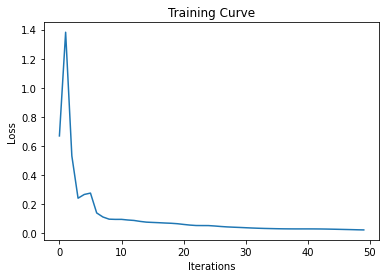

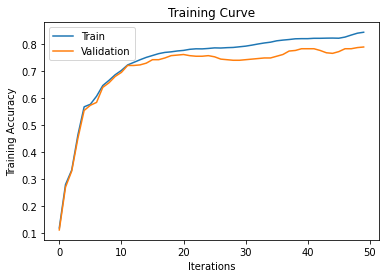

Final Training Accuracy: 0.8431163287086446
Final Validation Accuracy: 0.7884615384615384


In [ ]:
resNetClassify_single_fc = Waste_Classifier_One_Linear_Layer(name="fc_Res", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc = resNetClassify_single_fc.cuda()
train(resNetClassify_single_fc, feature_train_set, feature_val_set, batch_size=64, num_epochs=50, learning_rate=0.01)


# Predictions and Testing --> ResNet152

In [ ]:
# Load the tensors
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

In [ ]:
model = resnet152
model = nn.Sequential(*(list(resnet152.children())[0:9]))
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# Save resnet152 features
data_dir = '/root/datasets/ResNet152/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model, "ResNet152", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "ResNet152", train_set, train_dir, train_set.classes)
save_features(model, "ResNet152", val_set, val_dir, val_set.classes)
save_features(model, "ResNet152", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.16666666666666666, Training Loss: 0.1683596928914388, Validation Accuracy: 0.16666666666666666
Epoch 2: Train accuracy: 0.03333333333333333, Training Loss: 0.17751439412434897, Validation Accuracy: 0.03333333333333333
Epoch 3: Train accuracy: 0.1, Training Loss: 0.1698421319325765, Validation Accuracy: 0.1
Epoch 4: Train accuracy: 0.1, Training Loss: 0.15517180760701496, Validation Accuracy: 0.1
Epoch 5: Train accuracy: 0.13333333333333333, Training Loss: 0.1467239220937093, Validation Accuracy: 0.13333333333333333
Epoch 6: Train accuracy: 0.1, Training Loss: 0.1495499610900879, Validation Accuracy: 0.1
Epoch 7: Train accuracy: 0.23333333333333334, Training Loss: 0.15826651255289714, Validation Accuracy: 0.23333333333333334
Epoch 8: Train accuracy: 0.3333333333333333, Training Loss: 0.16441006660461427, Validation Accuracy: 0.3333333333333333
Epoch 9: Train accuracy: 0.1, Training Loss: 0.1623551368713379, Validation Accuracy: 0.1
Epoch 10: Train accuracy: 0.

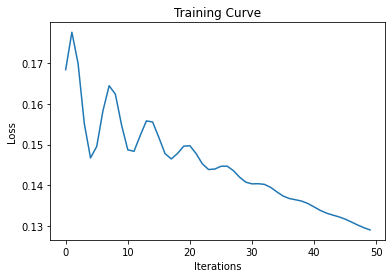

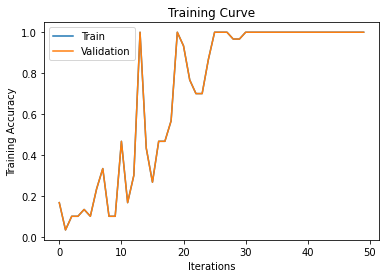

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with ResNet
res152_overfit = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_overfit = res152_overfit.cuda()
train(res152_overfit, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=50, learning_rate=0.005)

Epoch 1: Train accuracy: 0.10538954108858058, Training Loss: 0.48220375180244446, Validation Accuracy: 0.1047008547008547
Epoch 2: Train accuracy: 0.10965848452508005, Training Loss: 1.9039320945739746, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10859124866595518, Training Loss: 0.8213822245597839, Validation Accuracy: 0.10897435897435898
Epoch 4: Train accuracy: 0.10965848452508005, Training Loss: 0.7404787540435791, Validation Accuracy: 0.10897435897435898
Epoch 5: Train accuracy: 0.10965848452508005, Training Loss: 1.0685486793518066, Validation Accuracy: 0.10897435897435898
Epoch 6: Train accuracy: 0.10538954108858058, Training Loss: 0.5015890598297119, Validation Accuracy: 0.1047008547008547
Epoch 7: Train accuracy: 0.10538954108858058, Training Loss: 0.5470668077468872, Validation Accuracy: 0.1047008547008547
Epoch 8: Train accuracy: 0.10298826040554962, Training Loss: 1.5365906953811646, Validation Accuracy: 0.10256410256410256
Epoch 9: Train accuracy: 0

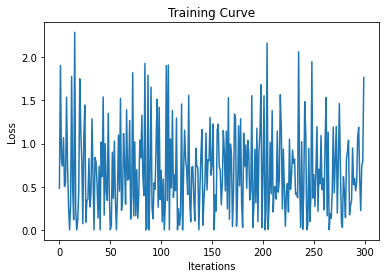

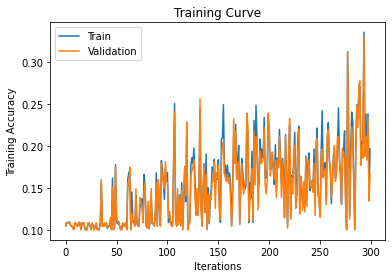

Final Training Accuracy: 0.19717182497331912
Final Validation Accuracy: 0.16666666666666666


In [ ]:
res152_1 = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_1 = res152_1.cuda()
train(res152_1, feature_train_set, feature_val_set, batch_size=128, num_epochs=300, learning_rate=0.02)

Epoch 1: Train accuracy: 0.11339381003201708, Training Loss: 0.021885816007852554, Validation Accuracy: 0.11752136752136752
Epoch 2: Train accuracy: 0.10965848452508005, Training Loss: 0.018244655802845955, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10965848452508005, Training Loss: 0.018003247678279877, Validation Accuracy: 0.10897435897435898
Epoch 4: Train accuracy: 0.10965848452508005, Training Loss: 0.018143195658922195, Validation Accuracy: 0.10897435897435898
Epoch 5: Train accuracy: 0.10965848452508005, Training Loss: 0.01813804730772972, Validation Accuracy: 0.10897435897435898
Epoch 6: Train accuracy: 0.10965848452508005, Training Loss: 0.01813030056655407, Validation Accuracy: 0.10897435897435898
Epoch 7: Train accuracy: 0.10965848452508005, Training Loss: 0.01812882348895073, Validation Accuracy: 0.10897435897435898
Epoch 8: Train accuracy: 0.10965848452508005, Training Loss: 0.018126878887414932, Validation Accuracy: 0.10897435897435898
Epoch 9: Tr

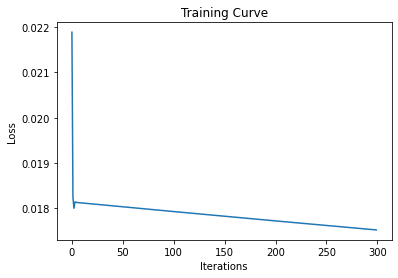

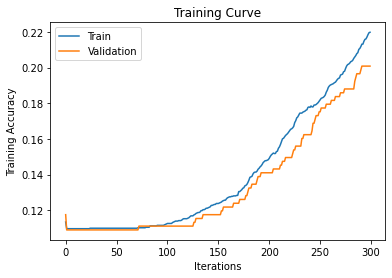

Final Training Accuracy: 0.2198505869797225
Final Validation Accuracy: 0.20085470085470086


In [ ]:
res152_3 = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_3 = res152_3.cuda()
train(res152_3, feature_train_set, feature_val_set, batch_size=128, num_epochs=300, learning_rate=0.0001)

Epoch 1: Train accuracy: 0.11339381003201708, Training Loss: 0.021885816007852554, Validation Accuracy: 0.11752136752136752
Epoch 2: Train accuracy: 0.10965848452508005, Training Loss: 0.018244655802845955, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10965848452508005, Training Loss: 0.018003247678279877, Validation Accuracy: 0.10897435897435898
Epoch 4: Train accuracy: 0.10965848452508005, Training Loss: 0.018143195658922195, Validation Accuracy: 0.10897435897435898
Epoch 5: Train accuracy: 0.10965848452508005, Training Loss: 0.01813804730772972, Validation Accuracy: 0.10897435897435898
Epoch 6: Train accuracy: 0.10965848452508005, Training Loss: 0.01813030056655407, Validation Accuracy: 0.10897435897435898
Epoch 7: Train accuracy: 0.10965848452508005, Training Loss: 0.01812882348895073, Validation Accuracy: 0.10897435897435898
Epoch 8: Train accuracy: 0.10965848452508005, Training Loss: 0.018126878887414932, Validation Accuracy: 0.10897435897435898
Epoch 9: Tr

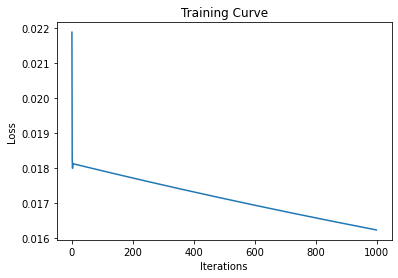

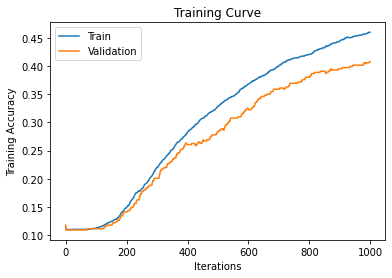

Final Training Accuracy: 0.4602454642475987
Final Validation Accuracy: 0.4081196581196581


In [ ]:
res152_4 = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_4 = res152_4.cuda()
train(res152_4, feature_train_set, feature_val_set, batch_size=128, num_epochs=1000, learning_rate=0.0001)

Epoch 1: Train accuracy: 0.10779082177161152, Training Loss: 0.009025409817695618, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10032017075773746, Training Loss: 0.009223383851349354, Validation Accuracy: 0.10042735042735043
Epoch 3: Train accuracy: 0.10032017075773746, Training Loss: 0.008874103426933289, Validation Accuracy: 0.10042735042735043
Epoch 4: Train accuracy: 0.10779082177161152, Training Loss: 0.008594154380261898, Validation Accuracy: 0.10897435897435898
Epoch 5: Train accuracy: 0.10779082177161152, Training Loss: 0.008419773541390896, Validation Accuracy: 0.10897435897435898
Epoch 6: Train accuracy: 0.10779082177161152, Training Loss: 0.008311948738992214, Validation Accuracy: 0.10897435897435898
Epoch 7: Train accuracy: 0.10779082177161152, Training Loss: 0.008248139172792435, Validation Accuracy: 0.10897435897435898
Epoch 8: Train accuracy: 0.10779082177161152, Training Loss: 0.008205716498196125, Validation Accuracy: 0.10897435897435898
Epoch 9:

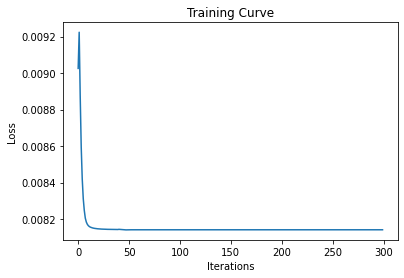

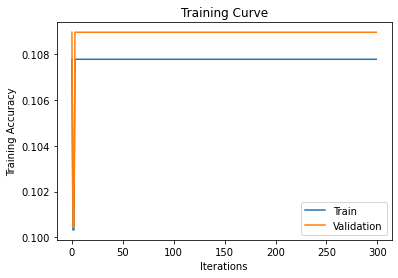

Final Training Accuracy: 0.10779082177161152
Final Validation Accuracy: 0.10897435897435898


In [ ]:
res152_2 = Waste_Classifier_MLP(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_2 = res152_2.cuda()
train(res152_2, feature_train_set, feature_val_set, batch_size=256, num_epochs=300, learning_rate=0.02)

Epoch 1: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 4: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 5: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 6: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 7: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 8: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 9: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 10: Train accuracy: 0.107790821

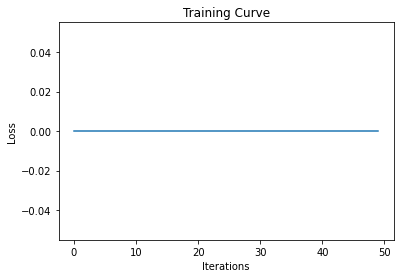

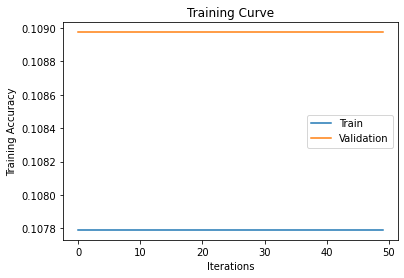

Final Training Accuracy: 0.10779082177161152
Final Validation Accuracy: 0.10897435897435898


In [ ]:
res152_6 = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_6 = res152_6.cuda()
train(res152_6, feature_train_set, feature_val_set, batch_size=15, num_epochs=50, learning_rate=0.001)

# Predictions and Testing --> Inception

Got up to 89% accuracy.

In [ ]:
inception = torchvision.models.inception_v3(pretrained=True)

In [ ]:
# Load the tensors
transformations_inception = transforms.Compose([                                     
  transforms.Resize((299,299)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
train_set_inception = torchvision.datasets.ImageFolder(train_path, transform=transformations_inception)
val_set_inception = torchvision.datasets.ImageFolder(val_path, transform=transformations_inception)
test_set_inception = torchvision.datasets.ImageFolder(test_path, transform=transformations_inception)
tiny_set_inception = torchvision.datasets.ImageFolder(tiny_path, transform=transformations_inception)

In [ ]:
inception.fc = nn.Identity()
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# save inception features
data_dir = '/root/datasets/Inception/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

# os.mkdir(data_dir)
model = inception
save_features(model, "inception", tiny_set_inception, tiny_dir, tiny_set_inception.classes)
save_features(model, "inception", train_set_inception, train_dir, train_set_inception.classes)
save_features(model, "inception", val_set_inception, val_dir, val_set_inception.classes)
save_features(model, "inception", test_set_inception, test_dir, test_set_inception.classes)


In [ ]:
feature_tiny_set_inception = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set_inception = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set_inception = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set_inception = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.03333333333333333, Training Loss: 0.07745150725046794, Validation Accuracy: 0.03333333333333333
Epoch 2: Train accuracy: 0.03333333333333333, Training Loss: 0.07734755674997966, Validation Accuracy: 0.03333333333333333
Epoch 3: Train accuracy: 0.03333333333333333, Training Loss: 0.07715221246083577, Validation Accuracy: 0.03333333333333333
Epoch 4: Train accuracy: 0.06666666666666667, Training Loss: 0.07687731583913167, Validation Accuracy: 0.06666666666666667
Epoch 5: Train accuracy: 0.1, Training Loss: 0.07652969360351562, Validation Accuracy: 0.1
Epoch 6: Train accuracy: 0.13333333333333333, Training Loss: 0.07612125873565674, Validation Accuracy: 0.13333333333333333
Epoch 7: Train accuracy: 0.2, Training Loss: 0.0756756067276001, Validation Accuracy: 0.2
Epoch 8: Train accuracy: 0.3, Training Loss: 0.07519900798797607, Validation Accuracy: 0.3
Epoch 9: Train accuracy: 0.4, Training Loss: 0.07469326655069987, Validation Accuracy: 0.4
Epoch 10: Train accura

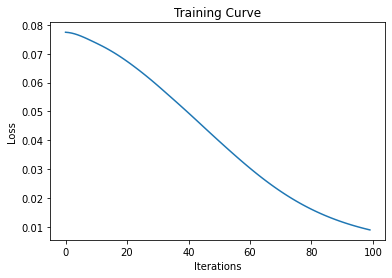

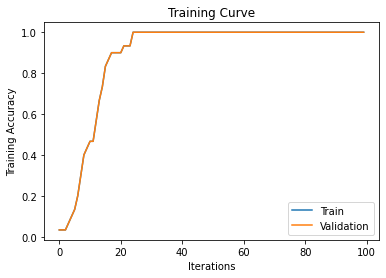

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Inception
inceptionClassify = Waste_Classifier_ANN(name="Waste_Inception", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_tiny_set_inception, feature_tiny_set_inception, batch_size=30, num_epochs=100, learning_rate=0.002)

In [ ]:
inceptionClassify = Waste_Classifier_ANN(name="Waste_InceptionANN", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=200, learning_rate=0.002)

Epoch 1: Train accuracy: 0.18996798292422626, Training Loss: 0.019606580957770348, Validation Accuracy: 0.17307692307692307
Epoch 2: Train accuracy: 0.16568836712913554, Training Loss: 0.01873674988746643, Validation Accuracy: 0.17735042735042736
Epoch 3: Train accuracy: 0.24946638207043756, Training Loss: 0.018812483176589012, Validation Accuracy: 0.2329059829059829
Epoch 4: Train accuracy: 0.25933831376734257, Training Loss: 0.018639596179127693, Validation Accuracy: 0.25213675213675213
Epoch 5: Train accuracy: 0.30389541088580574, Training Loss: 0.017276188358664513, Validation Accuracy: 0.31837606837606836
Epoch 6: Train accuracy: 0.36312700106723583, Training Loss: 0.01730886846780777, Validation Accuracy: 0.37606837606837606
Epoch 7: Train accuracy: 0.422358591248666, Training Loss: 0.016573091968894005, Validation Accuracy: 0.4166666666666667
Epoch 8: Train accuracy: 0.5146744930629669, Training Loss: 0.01618642359972, Validation Accuracy: 0.5213675213675214
Epoch 9: Train accur

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7fdb858293b0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt


Epoch 120: Train accuracy: 0.9743863393810032, Training Loss: 0.00030791189055889845, Validation Accuracy: 0.8931623931623932
Epoch 121: Train accuracy: 0.9749199573105657, Training Loss: 0.00030642864294350147, Validation Accuracy: 0.8931623931623932
Epoch 122: Train accuracy: 0.9751867662753468, Training Loss: 0.0003012650413438678, Validation Accuracy: 0.8888888888888888
Epoch 123: Train accuracy: 0.9762540021344717, Training Loss: 0.00029478961369022727, Validation Accuracy: 0.8910256410256411


KeyboardInterrupt: ignored

Epoch 1: Train accuracy: 0.12860192102454643, Training Loss: 0.018631301820278168, Validation Accuracy: 0.13247863247863248
Epoch 2: Train accuracy: 0.1536819637139808, Training Loss: 0.018326394259929657, Validation Accuracy: 0.16666666666666666
Epoch 3: Train accuracy: 0.21611526147278548, Training Loss: 0.018218310549855232, Validation Accuracy: 0.22863247863247863
Epoch 4: Train accuracy: 0.327641408751334, Training Loss: 0.017844485118985176, Validation Accuracy: 0.33547008547008544
Epoch 5: Train accuracy: 0.37593383137673425, Training Loss: 0.01758294552564621, Validation Accuracy: 0.3888888888888889
Epoch 6: Train accuracy: 0.4180896478121665, Training Loss: 0.01715194247663021, Validation Accuracy: 0.41239316239316237
Epoch 7: Train accuracy: 0.39354322305229456, Training Loss: 0.016708964481949806, Validation Accuracy: 0.405982905982906
Epoch 8: Train accuracy: 0.4426360725720384, Training Loss: 0.01598421484231949, Validation Accuracy: 0.452991452991453
Epoch 9: Train accura

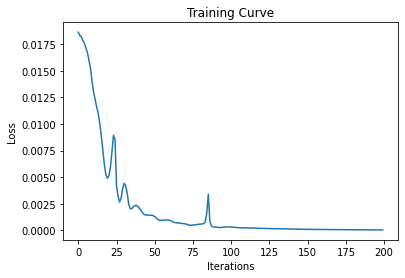

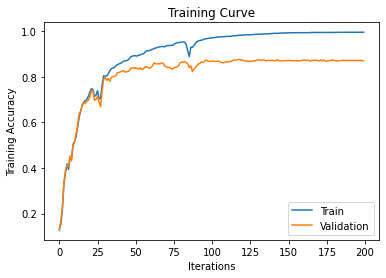

Final Training Accuracy: 0.9954642475987193
Final Validation Accuracy: 0.8696581196581197


In [ ]:
inceptionClassify = Waste_Classifier_MLP(name="Waste_InceptionMLP2", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=200, learning_rate=0.002)

# Predictions and Testing --> VGG16

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier = nn.Identity()
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
data_dir = '/root/datasets/VGG16/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = vgg16
save_features(model, "vgg16", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "vgg16", train_set, train_dir, train_set.classes)
save_features(model, "vgg16", val_set, val_dir, val_set.classes)
save_features(model, "vgg16", test_set, test_dir, test_set.classes)

In [ ]:
feature_tiny_set_vgg16 = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set_vgg16 = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set_vgg16 = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set_vgg16 = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.16666666666666666, Training Loss: 0.07910817464192708, Validation Accuracy: 0.16666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07488875389099121, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06929771105448405, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.06319302717844645, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 1.0, Training Loss: 0.055969858169555665, Validation Accuracy: 1.0
Epoch 6: Train accuracy: 1.0, Training Loss: 0.04799492756525676, Validation Accuracy: 1.0
Epoch 7: Train accuracy: 1.0, Training Loss: 0.039623486995697024, Validation Accuracy: 1.0
Epoch 8: Train accuracy: 1.0, Training Loss: 0.031514505545298256, Validation Accuracy: 1.0
Epoch 9: Train accuracy: 1.0, Training Loss: 0.024390508731206257, Validation Accuracy: 1.0
Epoch 10: Train accuracy: 1.0, Training Loss: 0.018466482559839886, Validation Accu

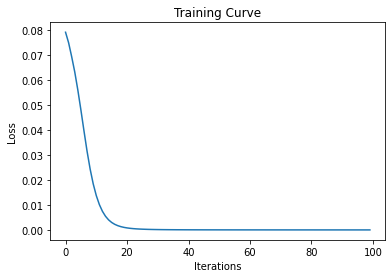

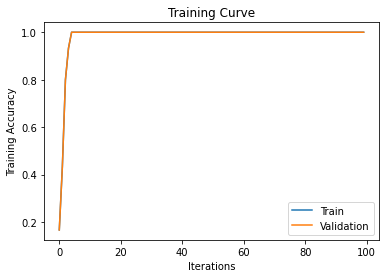

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
vgg16Classify = Waste_Classifier_ANN(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_tiny_set_vgg16, feature_tiny_set_vgg16, batch_size=30, num_epochs=100, learning_rate=0.002)

Epoch 1: Train accuracy: 0.23559231590181431, Training Loss: 0.01843496784567833, Validation Accuracy: 0.24572649572649571
Epoch 2: Train accuracy: 0.3105656350053362, Training Loss: 0.01794353872537613, Validation Accuracy: 0.31196581196581197
Epoch 3: Train accuracy: 0.4981323372465315, Training Loss: 0.01748044788837433, Validation Accuracy: 0.48504273504273504
Epoch 4: Train accuracy: 0.5843116328708644, Training Loss: 0.016587041318416595, Validation Accuracy: 0.5555555555555556
Epoch 5: Train accuracy: 0.6486125933831377, Training Loss: 0.014840720221400261, Validation Accuracy: 0.6217948717948718
Epoch 6: Train accuracy: 0.6891675560298826, Training Loss: 0.012902353890240192, Validation Accuracy: 0.6709401709401709
Epoch 7: Train accuracy: 0.7169156883671292, Training Loss: 0.01139439269900322, Validation Accuracy: 0.6987179487179487
Epoch 8: Train accuracy: 0.7353255069370331, Training Loss: 0.01010880060493946, Validation Accuracy: 0.7094017094017094
Epoch 9: Train accuracy: 

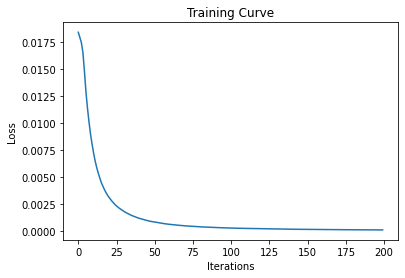

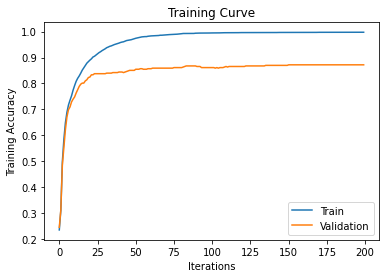

Final Training Accuracy: 0.9973319103521878
Final Validation Accuracy: 0.8717948717948718


In [ ]:
vgg16Classify = Waste_Classifier_ANN(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_train_set_vgg16, feature_val_set_vgg16, batch_size=128, num_epochs=200, learning_rate=0.00025)

Epoch 1: Train accuracy: 0.20624332977588047, Training Loss: 0.07717180252075195, Validation Accuracy: 0.20512820512820512
Epoch 2: Train accuracy: 0.2676093916755603, Training Loss: 0.07647629082202911, Validation Accuracy: 0.2692307692307692
Epoch 3: Train accuracy: 0.3289754535752401, Training Loss: 0.07022517174482346, Validation Accuracy: 0.32051282051282054
Epoch 4: Train accuracy: 0.3783351120597652, Training Loss: 0.0648365393280983, Validation Accuracy: 0.37393162393162394
Epoch 5: Train accuracy: 0.3890074706510139, Training Loss: 0.05760527402162552, Validation Accuracy: 0.391025641025641
Epoch 6: Train accuracy: 0.4119530416221985, Training Loss: 0.052759602665901184, Validation Accuracy: 0.41452991452991456
Epoch 7: Train accuracy: 0.44957310565635006, Training Loss: 0.047910045832395554, Validation Accuracy: 0.4465811965811966
Epoch 8: Train accuracy: 0.4957310565635005, Training Loss: 0.043403301388025284, Validation Accuracy: 0.47435897435897434
Epoch 9: Train accuracy:

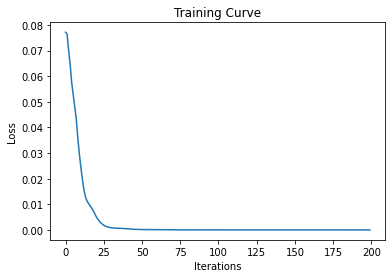

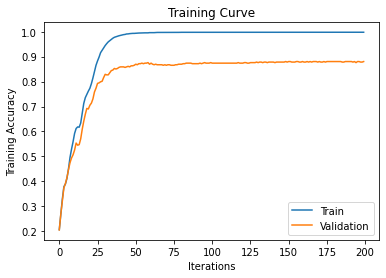

Final Training Accuracy: 0.9978655282817502
Final Validation Accuracy: 0.8803418803418803


In [ ]:
vgg16Classify = Waste_Classifier_MLP(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_train_set_vgg16, feature_val_set_vgg16, batch_size=32, num_epochs=200, learning_rate=0.0003)

# Baseline Model: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(tiny_set, batch_size=len(tiny_set), num_workers=1)
accuracy = 0
total = 0

for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))

  forest.fit(imgs, labels)
  predictions = forest.predict(imgs)

  accuracy += accuracy_score(predictions, labels)
  total += 1
print("Overfit accuracy:", accuracy/total)


Overfit accuracy: 1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), num_workers=1)
accuracy = 0
total = 0

for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))
  forest.fit(imgs, labels)

  val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), num_workers=1)
  for val_imgs, val_labels in val_loader:
    val_imgs = val_imgs.numpy()
    val_labels = val_labels.numpy()
    val_imgs = val_imgs.reshape((val_imgs.shape[0], val_imgs.shape[1]*val_imgs.shape[2]*val_imgs.shape[3]))
    predictions = forest.predict(val_imgs)
    accuracy += accuracy_score(predictions, val_labels)
    total += 1

print("Overfit accuracy:", accuracy/total)

Overfit accuracy: 0.5683760683760684
